In [4]:
import numpy as np
import math
import sympy as sym
from sympy.functions.elementary.trigonometric import atan2
from scipy.integrate import ode
from scipy.stats import linregress
from sympy.utilities.lambdify import lambdify
from IPython.core.debugger import Tracer
import Kep_2_Cart
import Cart_2_Kep
import filter_functions
import warnings
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display



In [5]:
print(np.degrees(latitude_grid[18]))
print(np.degrees(longitude_grid[36]))
indices = np.where(ensemble_of_measurements[0, 0, 0, :, :] != 0)


print(indices[0][10], indices[1][10])
print(indices[0][100], indices[1][100])
print(indices[0][400], indices[1][400])
print(indices[0][600], indices[1][600])

print(np.degrees(latitude_grid[32]), np.degrees(longitude_grid[17]))

NameError: name 'latitude_grid' is not defined

In [6]:
# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of State/Density Ensemble:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"


# read python dict containing measurements
ensemble_meas_file = open('Data Files/ensemble_of_meas_diffs.pkl', 'rb')#ensemble_of_measurements_every5.pkl
mydict2 = pickle.load(ensemble_meas_file)
ensemble_meas_file.close()
                          
ensemble_of_meas_diffs = mydict2['ensemble_of_meas_diffs'] 

num_of_meas = len(ensemble_of_meas_diffs[0, :, 0, 0, 0])#ensembles, meas, stations, lat, lon
num_of_stations = len(ensemble_of_meas_diffs[0, 0, :, 0, 0])#ensembles, meas, stations, lat, lon
print('Shape of Measurement Ensemble:', np.shape(ensemble_of_meas_diffs))

Shape of State/Density Ensemble: (450, 37, 73)
Shape of Measurement Ensemble: (450, 4, 3, 37, 73)


In [5]:
#Calculate Correlations/Beta values: linear regression between meas/az & state/density space
#https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

def calc_correlations(ensemble_of_measurements):
    
    cov = 0
    cor = 0

    #first 2 indices are for which az meas is being used, then one grid for each of those az lat/lon locations
    correlations_grid = np.zeros((num_of_meas, num_of_stations, num_of_lat, num_of_lon, num_of_lat, num_of_lon))
    
    for meas_index in range(num_of_meas):
        
        ensemble_az_measurements_allStations = ensemble_of_measurements[:, meas_index, :, :, :]
        

        for station_index in range(num_of_stations):
            print(station_index)

            ensemble_az_measurements = ensemble_az_measurements_allStations[:, station_index, :, :]

            for az_lat_index in range(num_of_lat):

                for az_lon_index in range(num_of_lon):

                    #vector of meas/azimuth ensemble values for this lat/lon combo
                    meas_vec = ensemble_az_measurements[:, az_lat_index, az_lon_index]

                    #determine if this is a lat/lon that the orbit went through, if not, move on to next lat/lon
                    if meas_vec[0] != 0:
                        #print(az_lat_index, az_lon_index)
                        #print(cov)
                        #print(cor)
                        #Tracer() ()
                        
                        #print('yes')
                        for ii in range(num_of_lat):

                            for jj in range(num_of_lon):
                                

                                #vector of state/density ensemble values for this lat/lon combo
                                #normalize density values so that there are near the magnitude of measurements
                                #idea: perhaps normalize density based on which meas using later 
                                state_vec = ensembles_of_density_grid[:, ii, jj] * 1e13 
                                
                                covInput = np.array([[*state_vec], [*meas_vec]])
                                cov = np.cov(covInput)
    
                                #Pearson's Correlation Coeff: cov(x,y)/(X std dev. * Y std dev.)
                                cor = cov[0,1]/(math.sqrt(cov[0,0])*math.sqrt(cov[1,1])) 
                                correlations_grid[meas_index, station_index, az_lat_index, az_lon_index, ii, jj] = cor
    
    
    return correlations_grid


#correlations_grid = calc_correlations(ensemble_of_measurements)

In [21]:
#Calculate variance of meas/az space, one variance for every lat/lon az ensemble

def calc_var(ensemble_of_measurements):

    #one az variance for each lat/lon
    variance_ensemble = np.zeros((num_of_meas, num_of_stations, num_of_lat, num_of_lon))
    
    for meas_index in range(num_of_meas):
        
        ensemble_az_measurements_allStations = ensemble_of_measurements[:, meas_index, :, :, :]

        for station_index in range(num_of_stations):
            print(station_index)

            ensemble_az_measurements = ensemble_az_measurements_allStations[:, station_index, :, :]

            for az_lat_index in range(num_of_lat):

                for az_lon_index in range(num_of_lon):

                    #vector of meas/azimuth ensemble values for this lat/lon combo
                    meas_vec = ensemble_az_measurements[:, az_lat_index, az_lon_index]

                    var = np.var(meas_vec)
                    variance_ensemble[meas_index, station_index, az_lat_index, az_lon_index] = var
                    
    return variance_ensemble

        

    

In [6]:

correlations_grid = calc_correlations(ensemble_of_meas_diffs)
#print('beta done')
#variance_ensemble = calc_var(ensemble_of_measurements)




0
1
2
0
1
2
0
1
2
0
1
2


0.0
-0.999923878612


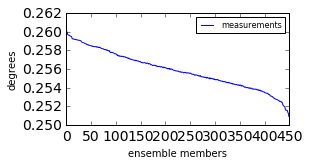

5.0
-0.999949885851


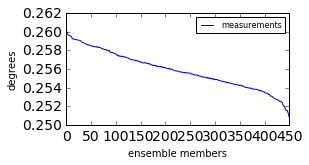

10.0
-0.999968998063


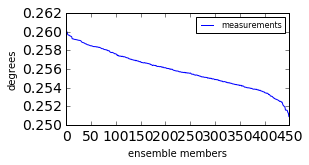

15.0
-0.999982362613


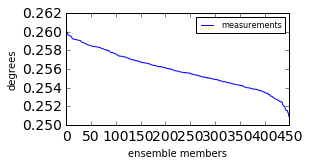

20.0
-0.999990989001


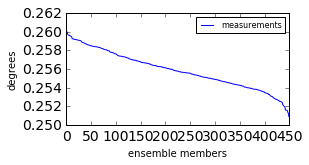

25.0
-0.999995778161


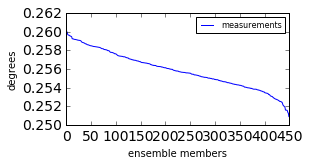

30.0
-0.999997544301


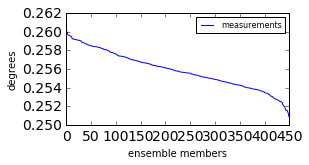

35.0
-0.999997029917


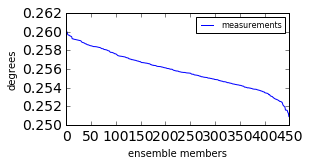

40.0
-0.999994920832


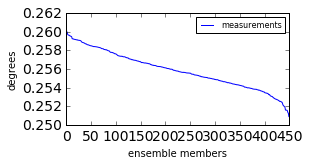

45.0
-0.999991865448


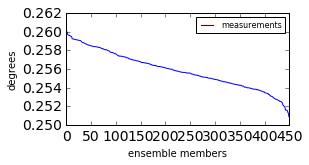

50.0
-0.999988493366


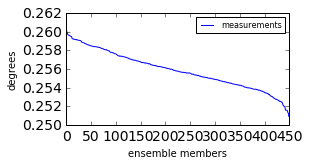

55.0
-0.99998541795


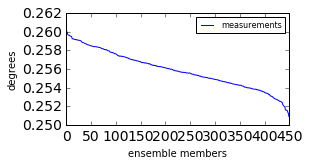

60.0
-0.999983200152


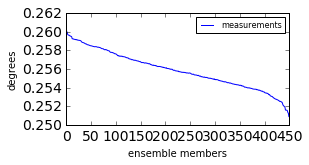

65.0
-0.99998225106


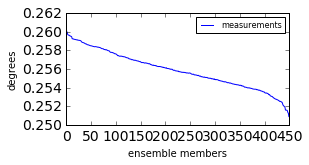

70.0
-0.999982662536


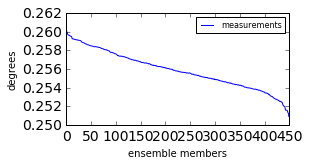

75.0
-0.99998398221


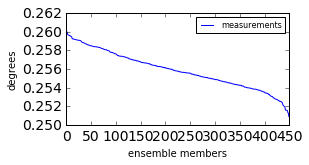

80.0
-0.999984988468


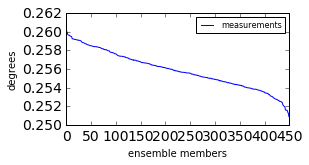

85.0
-0.999983558047


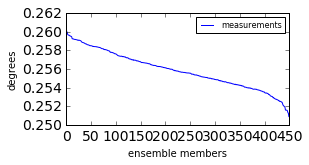

90.0
-0.999976726771


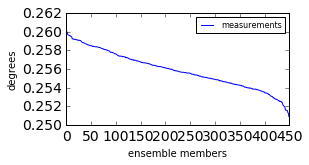

95.0
-0.999960999373


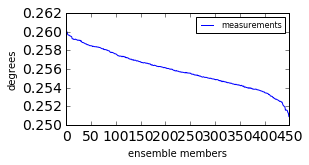

100.0
-0.999932871161


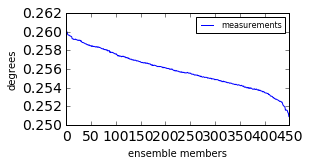

105.0
-0.999889424351


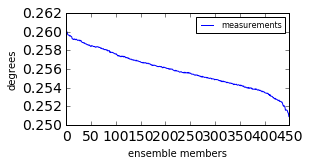

110.0
-0.999828813592


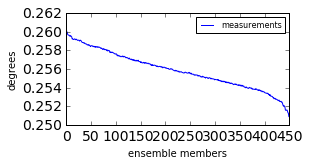

115.0
-0.999750491704


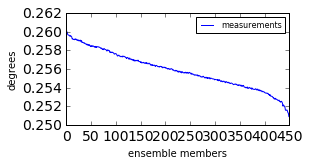

120.0
-0.999655129323


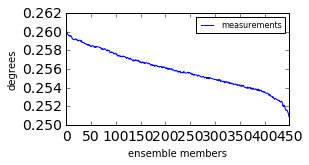

125.0
-0.999544294391


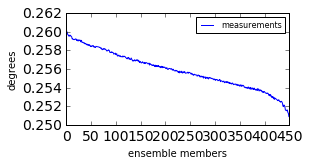

130.0
-0.999420024422


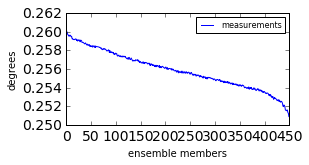

135.0
-0.999284426151


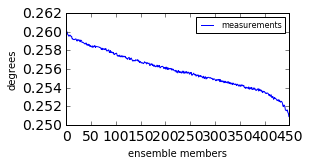

140.0
-0.999139391131


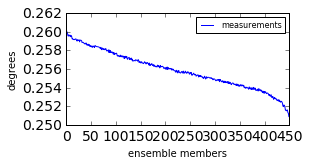

145.0
-0.998986457296


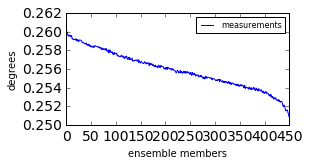

150.0
-0.998826803603


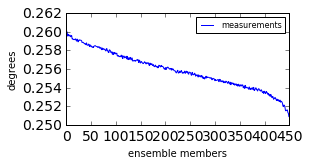

155.0
-0.998661345978


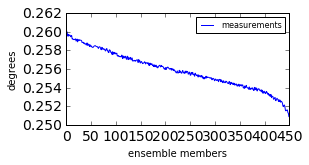

160.0
-0.998490900227


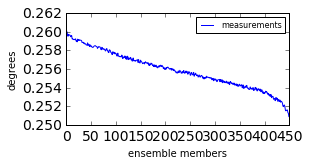

165.0
-0.998316378886


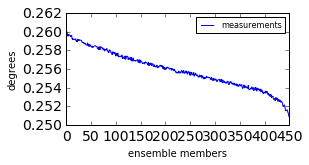

170.0
-0.998138987619


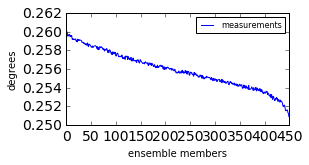

175.0
-0.997960384982


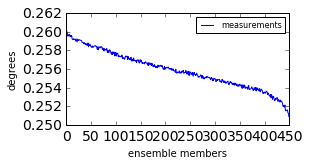

180.0
-0.997782772988


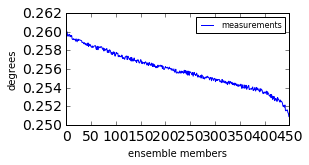

185.0
-0.997608898353


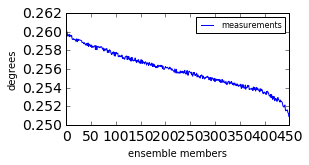

190.0
-0.997441963186


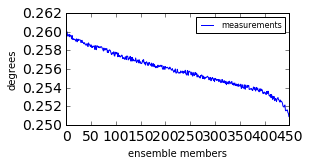

195.0
-0.997285462815


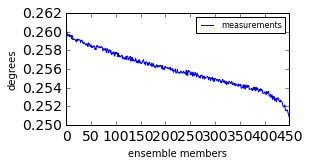

200.0
-0.997142981447


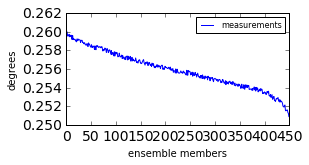

205.0
-0.997017980218


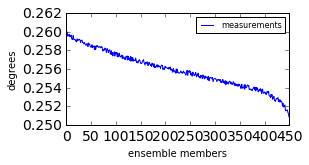

210.0
-0.996913607385


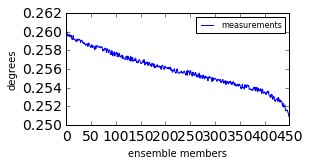

215.0
-0.996832549616


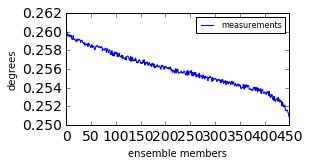

220.0
-0.996776930253


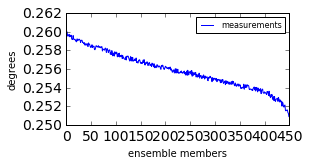

225.0
-0.996748248681


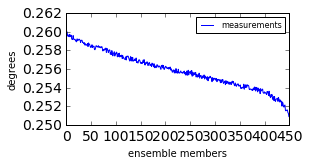

230.0
-0.996747347667


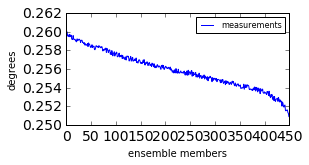

235.0
-0.996774394338


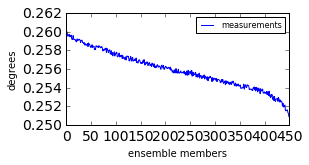

240.0
-0.996828865422


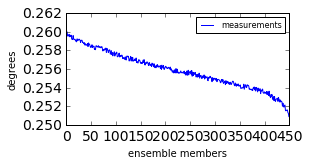

245.0
-0.996909536287


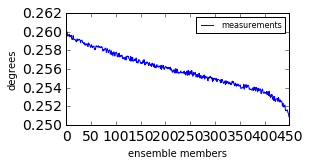

250.0
-0.997014483319


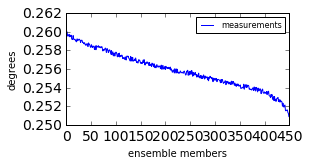

255.0
-0.997141116798


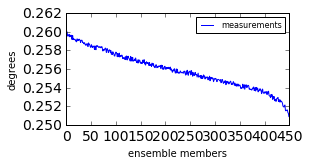

260.0
-0.997286264096


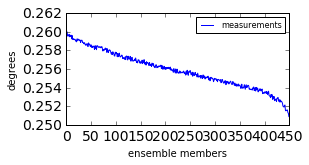

265.0
-0.997446318173


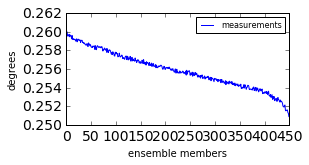

270.0
-0.997617452478


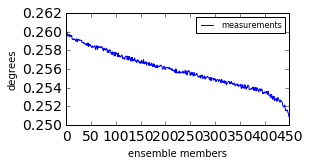

275.0
-0.997795881422


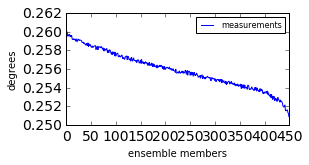

280.0
-0.997978121585


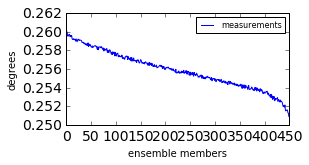

285.0
-0.998161193381


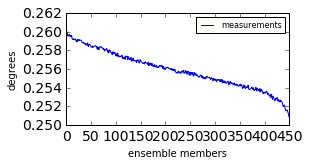

290.0
-0.998342707091


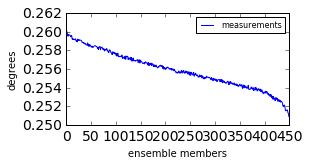

295.0
-0.998520805703


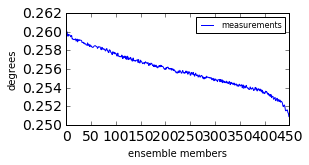

300.0
-0.998693983223


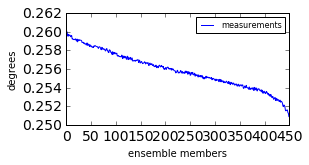

305.0
-0.998860844462


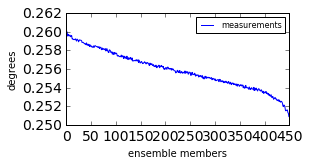

310.0
-0.999019899883


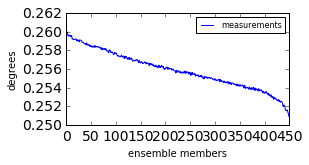

315.0
-0.999169481481


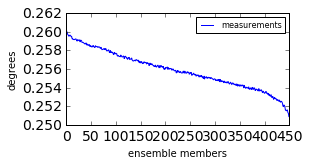

320.0
-0.999307821208


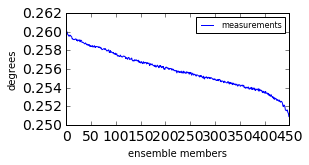

325.0
-0.999433268136


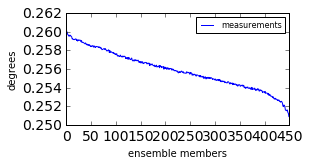

330.0
-0.999544563058


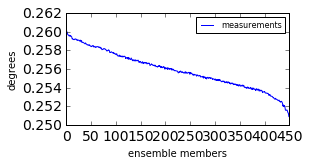

335.0
-0.999641066612


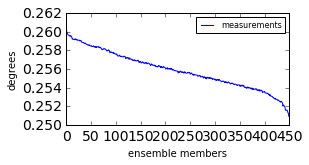

340.0
-0.99972285962


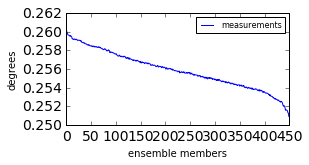

345.0
-0.999790689236


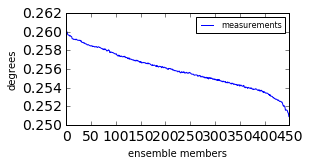

350.0
-0.999845793508


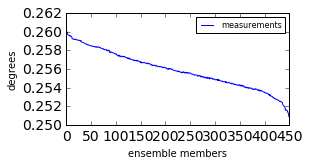

355.0
-0.999889673373


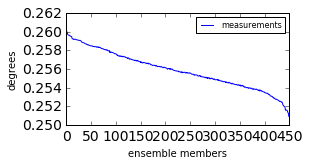

360.0
-0.999923883642


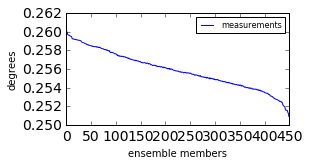

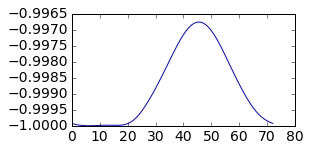

In [43]:
#Calculate Correlations/Beta values: linear regression between meas/az & state/density space
#https://en.wikipedia.org/wiki/Pearson_correlation_coefficient


plt.rcParams['figure.figsize'] = (4.0, 2.0)
    
cov = 0
cor = 0

#first 2 indices are for which az meas is being used, then one grid for each of those az lat/lon locations
correlations_grid = np.zeros((num_of_lat, num_of_lon))


    
meas_index = 3
ensemble_az_measurements_allStations = ensemble_of_meas_diffs[:, meas_index, :, :, :]

station_index = 0
ensemble_az_measurements = ensemble_az_measurements_allStations[:, station_index, :, :]


#for az_lat_index in range(num_of_lat):

    #for az_lon_index in range(num_of_lon):

az_lat_index = 18
az_lon_index = 1

#vector of meas/azimuth ensemble values for this lat/lon combo
meas_vec = ensemble_az_measurements[:, az_lat_index, az_lon_index]


#for ii in range(num_of_lat):
ii = 18

for jj in range(num_of_lon):


    #vector of state/density ensemble values for this lat/lon combo
    #normalize density values so that there are near the magnitude of measurements
    #idea: perhaps normalize density based on which meas using later 
    state_vec = ensembles_of_density_grid[:, ii, jj] * 1e13 

    covInput = np.array([[*state_vec], [*meas_vec]])
    
    cov = np.cov(covInput)

    #Pearson's Correlation Coeff: cov(x,y)/(X std dev. * Y std dev.)
    cor = cov[0,1]/(math.sqrt(cov[0,0])*math.sqrt(cov[1,1])) 
    correlations_grid[ii, jj] = cor
    
    print(np.degrees(longitude_grid[jj]))
    print(cor)
    
    sort_indices = np.argsort(state_vec)
    state_vec_sorted = state_vec[sort_indices]
    meas_vec_sorted = meas_vec[sort_indices]
    
    #plt.plot(state_vec_sorted, c='r')
    plt.plot(np.degrees(meas_vec_sorted), c='b')
    legend_names = ['measurements']#'state/density', 
    plt.legend(legend_names, fontsize=8)
    plt.ylabel('degrees')
    plt.xlabel('ensemble members')
    plt.show()


plt.plot(correlations_grid[18, :])
plt.show()

[[ 0.066273616191708 -0.034519377690708]
 [-0.034519377690708  0.017982443302649]]
-0.999926950221


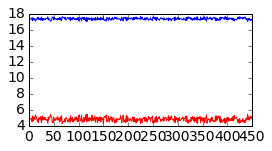

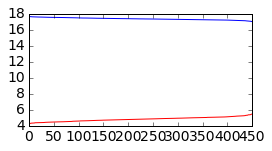

In [22]:

sort_indices = np.argsort(state_vec)
state_vec_sorted = state_vec[sort_indices]
meas_vec_sorted = meas_vec[sort_indices]

covInput = np.array([[*state_vec_sorted], [*meas_vec_sorted]])
    
cov = np.cov(covInput)
print(cov)

#Pearson's Correlation Coeff: cov(x,y)/(X std dev. * Y std dev.)
cor = cov[0,1]/(math.sqrt(cov[0,0])*math.sqrt(cov[1,1])) 
print(cor)

plt.plot(state_vec, c='r')
plt.plot(meas_vec, c='b')
plt.show()

plt.plot(state_vec_sorted, c='r')
plt.plot(meas_vec_sorted, c='b')
plt.show()

In [19]:
print(cov)
print(cor1)

[[ 0.066273616191708 -0.034519377690708]
 [-0.034519377690708  0.017982443302649]]
-0.999926950221


80.0
0.0


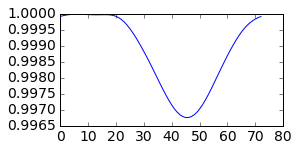

5.0


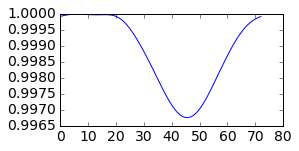

10.0


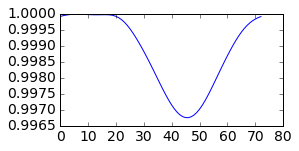

15.0


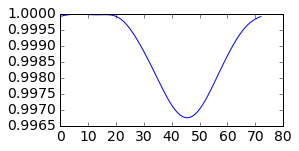

20.0


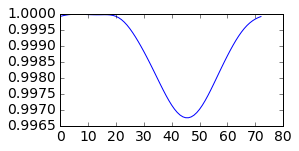

25.0


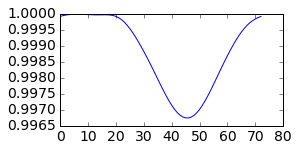

30.0


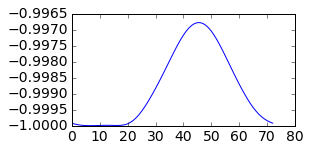

35.0


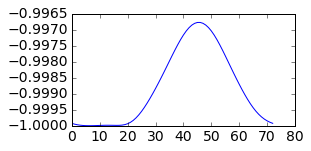

40.0


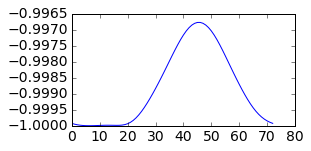

45.0


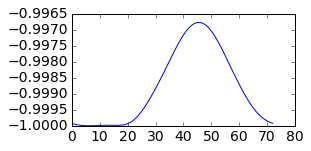

50.0


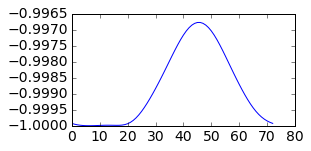

55.0


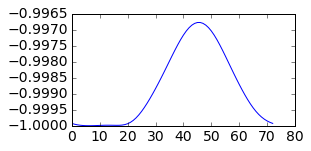

60.0


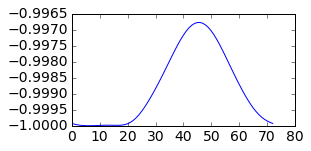

65.0


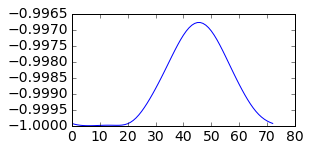

70.0


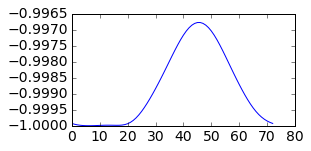

75.0


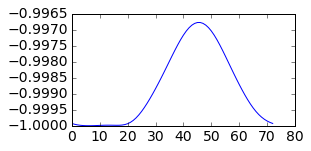

80.0


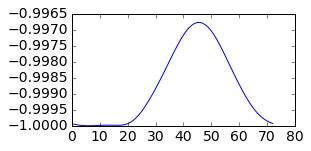

85.0


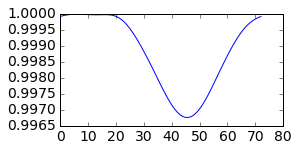

90.0


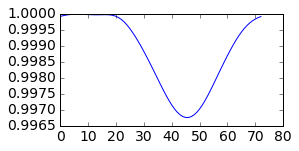

95.0


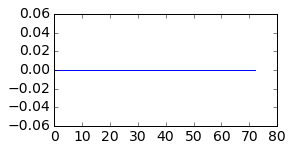

100.0


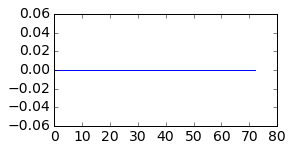

105.0


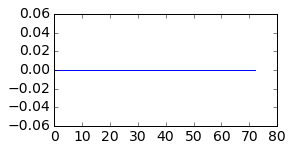

110.0


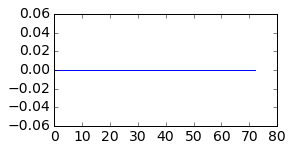

115.0


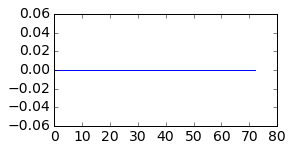

120.0


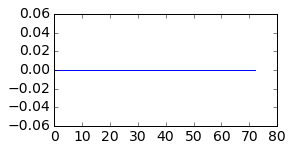

125.0


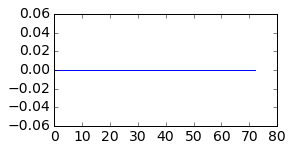

130.0


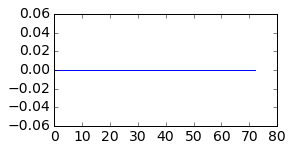

135.0


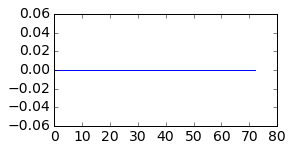

140.0


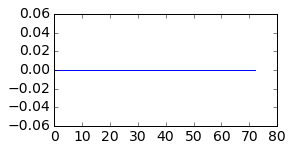

145.0


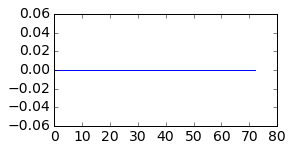

150.0


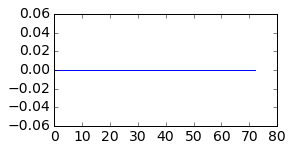

155.0


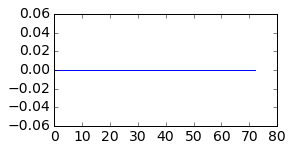

160.0


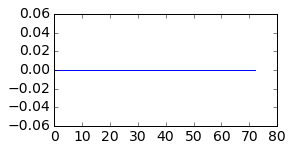

165.0


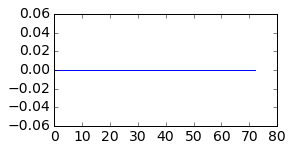

170.0


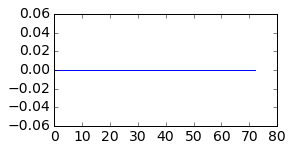

175.0


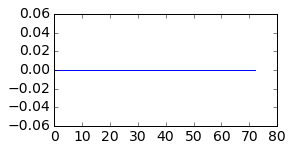

180.0


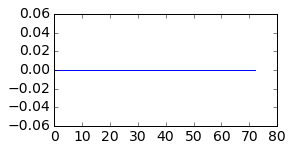

185.0


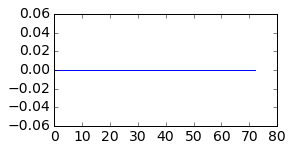

190.0


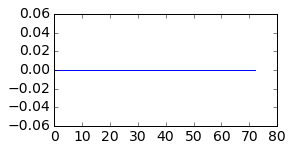

195.0


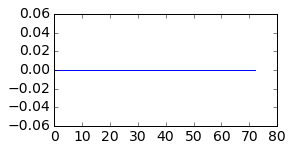

200.0


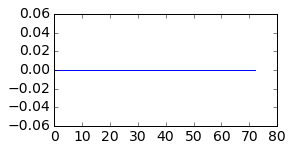

205.0


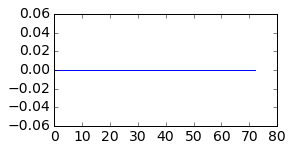

210.0


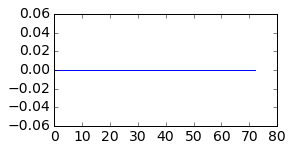

215.0


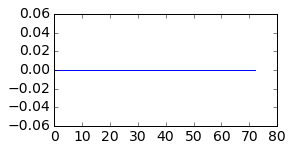

220.0


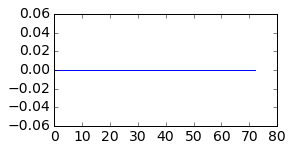

225.0


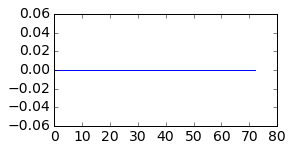

230.0


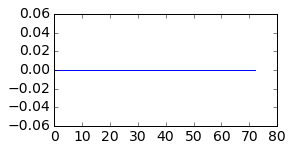

235.0


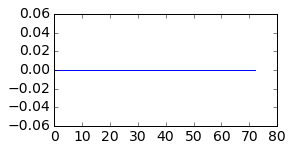

240.0


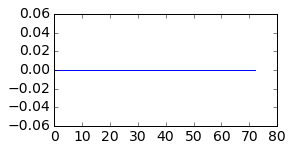

245.0


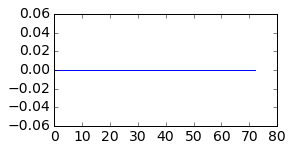

250.0


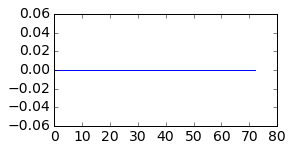

255.0


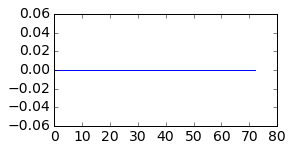

260.0


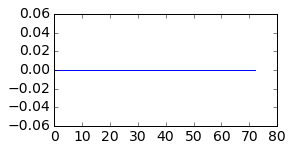

265.0


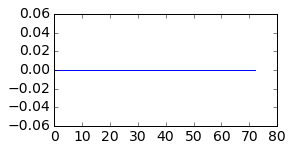

270.0


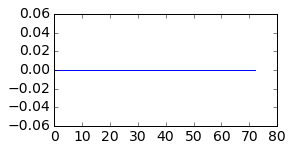

275.0


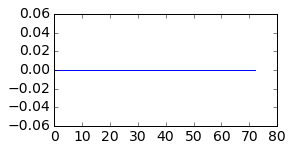

280.0


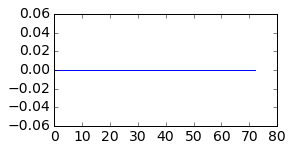

285.0


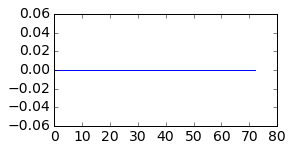

290.0


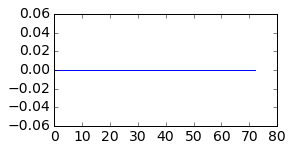

295.0


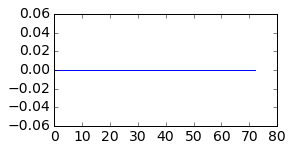

300.0


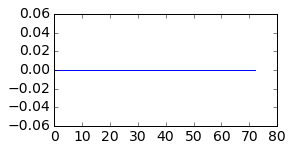

305.0


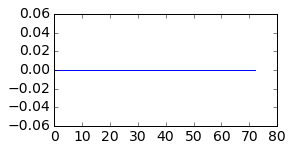

310.0


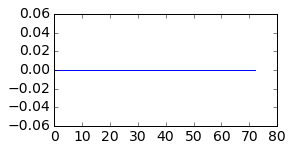

315.0


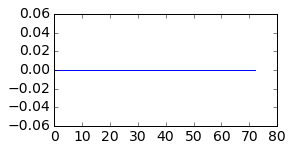

320.0


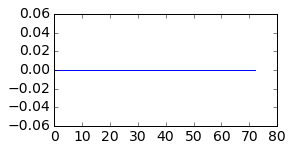

325.0


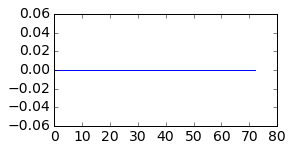

330.0


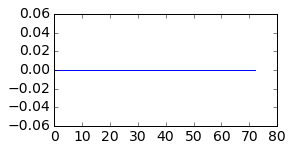

335.0


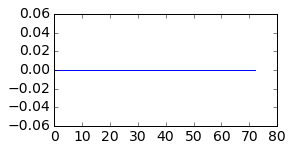

340.0


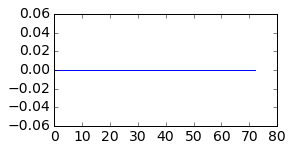

345.0


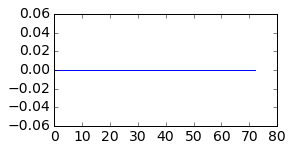

350.0


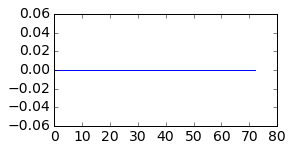

355.0


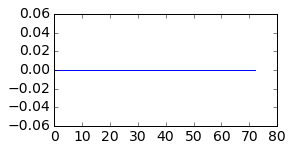

360.0


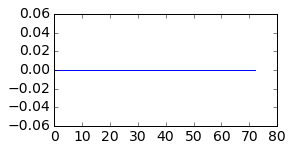

In [38]:
print(np.degrees(longitude_grid[16]))
plt.rcParams['figure.figsize'] = (4.0, 2.0)

for ii in range(len(correlations_grid[0, 0, 18, 16, 18, :])):
    print(np.degrees(longitude_grid[ii]))
    plt.plot(correlations_grid[0, 0, 18, ii, 18, :])

    plt.show()

In [ ]:
#write beta & variance arrays to file

mydict = {'cor_ensemble': correlations_grid}#, 'variance_ensemble': variance_ensemble}
output = open('Data Files/ensemble_cor_var.pkl', 'wb')
pickle.dump(mydict, output)
output.close()

import scipy.io
scipy.io.savemat("Data Files/ensemble_cor.mat", mdict={'cor_ensemble': correlations_grid})

In [51]:

print(np.where(correlations_grid[0,0,:,:,0,0] != 0)[0])
print(np.where(correlations_grid[0,0,:,:,0,0] != 0)[1])

correlations_grid[0,0,17,6,:,:]

[ 9  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 15 15 15 16 16 16 17
 17 18 18 19 19 19 20 20 21 21 22 22 22 23 23 23 24 24 25 25 25 25 26 26 26
 26 27 27 27]
[ 9 10 11 12  8  9 12  8 12 13  7  8 13  7 13 14  7 14  6  7 14  6 14 15  6
 15  6 15  5  6 15  5 16  5 16  4  5 16  4 16 17  4 17  3  4 17 18  0  2  3
 18  0  1  2]


array([[-0.96281284162113 , -0.962812844557979, -0.962812847155533, ...,
        -0.962812834821984, -0.962812838367911, -0.962812841621652],
       [-0.957660666818918, -0.957264731219876, -0.956912763840563, ...,
        -0.958570061455752, -0.958096989150645, -0.95766059664822 ],
       [-0.9572216303094  , -0.956487287345081, -0.955828702724207, ...,
        -0.958889945627589, -0.958024778710495, -0.957221500672573],
       ..., 
       [-0.996887448405002, -0.996752381824153, -0.996628114369616, ...,
        -0.997178583054802, -0.997030482536842, -0.996887424910089],
       [-0.997464850392401, -0.997407267930152, -0.997354238460086, ...,
        -0.997590363145765, -0.997526158619747, -0.99746484035942 ],
       [-0.997925579210038, -0.997925579571152, -0.997925579898619, ...,
        -0.997925578398169, -0.997925578818093, -0.997925579210101]])

In [46]:
distances = gen_distances()

NameError: name 'gen_distances' is not defined

In [ ]:
#generate array of possible distances

def gen_distances():

    distances = np.array([])

    #for lat_index in range(num_of_lat):

        #for lon_index in range(num_of_lon):

    lat_index = 18
    lon_index = 36

    density = ensembles_of_density_grid[0, lat_index, lon_index]


    for ii in range(num_of_lat):

        lat_dist = np.absolute(lat_index - ii) * lat_res

        for jj in range(num_of_lon):#num_of_lon

            lon_dist = np.absolute(lon_index - jj) * lon_res

            dist = (lat_dist**2 + lon_dist**2)**(1/2)

            indices = np.where(distances == dist)[0]
            if len(indices) == 0:
                distances = np.append(distances, dist)
                        
    return distances



#Calculate variogram 
def gen_variogram(distances):
    
    max_first_zero = 0
    

    #one az variogram for each lat/lon
    variogram_array = np.zeros((3, num_of_lat, num_of_lon, 500))
    single_varigram = np.zeros((len(distances), 20))

    #for lat_index in range(num_of_lat):
        #for lon_index in range(num_of_lon):

    lat_index = 18
    lon_index = 36


    density = ensembles_of_density_grid[0, lat_index, lon_index]


    for ii in range(num_of_lat):

        lat_dist = np.absolute(lat_index - ii) * lat_res


        for jj in range(num_of_lon):

            lon_dist = np.absolute(lon_index - jj) * lon_res
            dist = (lat_dist**2 + lon_dist**2)**(1/2)


            density2 = ensembles_of_density_grid[0, ii, jj]
            val = (density - density2)**2


            index = np.where(distances == dist)[0][0]


            first_zero = np.where(single_varigram[index] == 0)[0][0]

            if first_zero > max_first_zero:
                max_first_zero = first_zero
                index_ = index
                #print(first_zero)


            single_varigram[index, first_zero] = val


    variogram_result = np.zeros(len(distances))      

    for ii in range(len(distances)):

        non_zero_indices = np.where(single_varigram[index] != 0)[0]
        variogram_result[ii] = np.mean(single_varigram[ii, non_zero_indices])
    
    #print(np.degrees(max_dist), ii_, jj_)
        
    return variogram_result




variogram_result = gen_variogram(distances)

fig = plt.figure()
plt.scatter(np.degrees(distances), variogram_result*1e25)
plt.ylabel(r'Density Variation $(10^{-25}$ $kg/m^3)$', fontsize=18)
plt.xlabel('Relative Distances (degrees)', fontsize=18)
plt.title('Variogram', fontsize=18)
plt.show()


In [ ]:
#plot one of the az lat/lon's beta grid


# read python dict containing beta and variance
beta_var_file = open('Data Files/ensemble_beta_var_120s.pkl', 'rb')
mydict2 = pickle.load(beta_var_file)
beta_var_file.close()
correlations_grid = mydict2['correlations_grid']
variance_ensemble = mydict2['variance_ensemble']



latitudes = np.arange(-90, 91, 5)
longitudes = np.arange(0, 361, 5)

X, Y = np.meshgrid(longitudes, latitudes)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, correlations_grid[0, 20, 10, :, :]) #10, 0
ax.set_xlabel('longitude', fontsize=16)
ax.set_ylabel('latitude', fontsize=16)
ax.set_zlabel('Beta', fontsize=18)
ax.set_title('Beta/Cov btwn State/density & Meas/azimuth', fontsize=16)
plt.show()

In [ ]:
#Plot variance of meas/az space, one variance for every lat/lon az ensemble

print(np.shape(variance_ensemble))

variance_ensemble_new = np.degrees(variance_ensemble*1e10)-math.floor(np.degrees(variance_ensemble[0,10,0]*1e10))

print(np.shape(variance_ensemble_new))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, variance_ensemble_new[0]) #10, 0
ax.set_xlabel('longitude', fontsize=16)
ax.set_ylabel('latitude', fontsize=16)
ax.set_zlabel('Beta', fontsize=18)
ax.set_title('Variance of Az/Meas', fontsize=16)
plt.show()